In [229]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm
import mpmath as mp
from scipy.optimize import root_scalar as root


In [230]:
def psi(g,e):
    return np.array([g, e])
    
def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

In [231]:
def rho(delta, Omega0, rho22, t):
    Omega = np.sqrt(Omega0**2+ delta**2)
    return 0.69*(Omega0/Omega*np.sin(Omega*t/2))**2-rho22
def rho2deltaRabi(Omega0, rho22, t):
    return root(rho, args=(Omega0,rho22, t), bracket=[0,2*Omega0]).root

def rhoRamsey(delta, Omega0, rho22, t, T):
    psi0 = psi(1.0, 0.0)
    return rhoee(pulse(t, Omega0, delta, 0.0, 0.0)@pulse(T, 0.0, delta, 0.0, 0.0)@pulse(t, Omega0, delta, 0.0, 0.0)@psi0)-rho22
def rho2deltaRamsey(Omega0, rho22, t, T):
    return root(rhoRamsey, args=(Omega0,rho22, t, T), bracket=[0.0,Omega0/3]).root

In [232]:
def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

In [233]:
def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 80  #-----------cut off points while servo grabs---------------
    taoms=mat['aomfrequsmatrix'][ni:n,0]
    #print(ts[0])

    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom1=mat['aomfrequsmatrix'][ni:n,1]
    fe2aom2=mat['aomfrequsmatrix'][ni:n,2]
    fe2aom3=mat['aomfrequsmatrix'][ni:n,3]
    fe2aoms = [fe2aom1,fe2aom2,fe2aom3]
    fe3aom=mat['aomfrequsmatrix'][ni:n,4]
    rRquad1=mat['aomfrequsmatrix'][ni+1:n,6]
    rRquad2=mat['aomfrequsmatrix'][ni+1:n,7]
    rRquad3=mat['aomfrequsmatrix'][ni+1:n,8]
    rRquads = [rRquad1,rRquad2,rRquad3]
    rRoct = mat['aomfrequsmatrix'][ni+1:n,10]
    return taoms, fe2aoms, fe3aom, rRquads, rRoct

In [234]:
T = 150e-3
t = 20e-3
Omega0 = np.pi/(2*t)
rho2deltaRamsey(Omega0, 0.49587, t, T)/(2.0*np.pi) - rho2deltaRamsey(Omega0, 0.49587+0.037, t, T)/(2.0*np.pi)

0.06718135305734574

In [235]:
psi0 = psi(1.0, 0.0)
dets = np.linspace(-10*2*np.pi, 10*2*np.pi, 1000)
t = 40e-3
Omega0 = np.pi/(t*2)
rho22s = np.zeros(np.size(dets))
for ii in range(np.size(dets)):
    rho22s[ii] = rhoee(pulse(t, Omega0, dets[ii], 0.0, 0.0)@pulse(T, 0.0, dets[ii], 0.0, 0.0)@pulse(t, Omega0, dets[ii], 0.0, 0.0)@psi0)

In [236]:
Omega0/(2.0*np.pi)/2

3.125

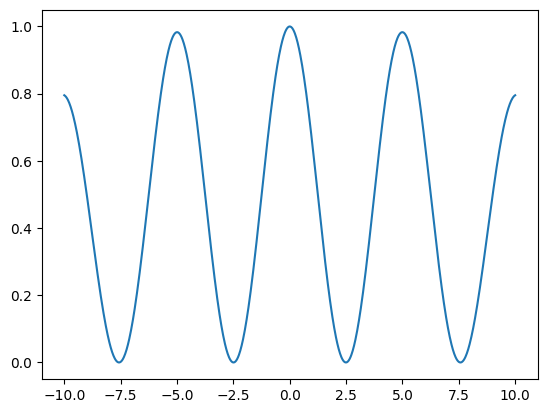

In [237]:
plt.plot(dets/(2.0*np.pi), rho22s)

In [238]:

t = 40e-3
Omega0 = np.pi/(t)
rho2deltaRabi(Omega0, 0.3483, t)/(2.0*np.pi) - rho2deltaRabi(Omega0, 0.3483+0.0016, t)/(2.0*np.pi)

0.03053217654753837

In [239]:
rho2deltaRabi(Omega0, 0.30116083130499904, t)/(2.0*np.pi) - rho2deltaRabi(Omega0, 0.299475753604194, t)/(2.0*np.pi)

-0.0328052245024395

In [240]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250918_1_a.mat"
taoms, fe2aoms, fe3aom, rRquads, rRoct = importMatlab(aomFile)


In [253]:
def servoError(aomFile, tRabi, tRamsey, t):
    taoms, fe2aoms, fe3aom, rRquads, rRoct = importMatlab(aomFile)
    rLquads = calcLeftExcsQuad(rRquads)
    rLoct = calcLeftExcsOct(rRoct)
    octServoErr = (rho2deltaRamsey(np.pi/(2*tRamsey), np.average(rLoct), t, tRamsey)- rho2deltaRamsey(np.pi/(2*tRamsey), np.average(rLoct), t, tRamsey))/(2.0*np.pi)
    quadServoErrs = np.zeros(3)
    for ii in range(3):
        quadServoErr[ii] = (rho2deltaRabi(np.pi/tRabi, np.average(rLquad[ii]), t) - rho2deltaRabi(np.pi/tRabi, np.average(rLquad[ii]), t))/(2.0*np.pi)
    return octServoErr, quadServoErrs

In [254]:
def calcLeftExcsQuad(rRquads):
    deltafrequQuad = 15*28/40
    g = deltafrequQuad/30
    rLquads = [np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0]))]
    for jj in range(3):
        for ii in range(np.size(rRquads[0])):
            rLquads[jj][ii] = rRquads[jj][ii]-0.5*(fe2aoms[jj][ii+1]-fe2aoms[jj][ii])/g
    if np.min(rLquads)<(-0.1) or np.max(rLquads)>1.1: print("Warning!!! Excitation fraction calc error")
    for jj in range(3):
        rLquads[jj] = np.round(rLquads[jj]*2)/2
    return rLquads

def calcLeftExcsOct(rRoct):
    tekDeltafrequ = 13*3/4
    g = tekDeltafrequ/(3*30*2)
    rLoct = np.zeros(np.size(rRoct))
    for ii in range(np.size(rRoct)):
        rLoct[ii] = rRoct[ii]+0.5*(fe3aom[ii+1]-fe3aom[ii])/g
    
    if np.min(rLoct)<(-0.1) or np.max(rLoct)>1.1: print("Warning!!! Excitation fraction calc error")
    rLoct = np.round(rLoct*2)/2
    return rLoct

In [242]:
rL1

np.float64(0.30116083130499904)

In [243]:
rR1

np.float64(0.299475753604194)

In [244]:
t = 40e-3
Omega0 = np.pi/(t)
rL1 = np.average(rLquads[0])
rR1 = np.average(rRquads[0])
rho2deltaRabi(Omega0, rL1, t)/(2.0*np.pi) - rho2deltaRabi(Omega0, rR1, t)/(2.0*np.pi)

-0.0328052245024395

In [246]:
rLoct

array([1. , 1. , 0.5, ..., 0.5, 1. , 0.5])

In [247]:
np.average(rLoct)

np.float64(0.4957873057479873)

In [248]:
np.average(rRoct)

np.float64(0.5021531548399176)

In [249]:
tekDeltafrequ = 13*3/4
g = tekDeltafrequ/(3*30*2)
N = np.size(fe3aom)
(fe3aom[N-1]-fe3aom[0])/(N*g)

np.float64(-0.012729313486653656)

In [250]:
np.average(rRoct)+(fe3aom[N-1]-fe3aom[0])/(N*g) 

np.float64(0.48942384135326394)

In [251]:
np.average(rRoct)

np.float64(0.5021531548399176)

In [252]:
T = 150e-3
t = 24e-3
Omega0 = np.pi/(2*t)
rho2deltaRamsey(Omega0, 0.5148824683265713, t, T)/(2.0*np.pi) - rho2deltaRamsey(Omega0, 0.5021531548399176, t, T)/(2.0*np.pi)

-0.022453603317049042